# Different sources have different prices for the same currency pair

Some sources look at currency futures, some at spot. Currencies are traded 24/7 so depending on the time at which a "close" is computed, you could land up with different prices.

pluto has 3 different sources for USDINR: Fred, Nse Futures and AlphaVantage. Here, we will look at how differ from one-another.

In [2]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)
library(reshape2)
library(ggrepel)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
currencies <- Currencies()
fred<-Fred()

In [3]:
# sample: https://github.com/shyams80/plutons/blob/master/docs-R/Currencies.ipynb
# from the sample, we know that USDINR started trading on the NSE from 2010-10-29 
# but AlphaVantage data goes back only to 2014-11-07

# sample: http://pluto.studio/user/shyams80/notebooks/docs-R/Fred.ipynb, Fred series is DEXINUS -2147478748
startDate <- as.Date("2014-11-07")

fredFx <- fred$TimeSeries() %>% 
    filter(SERIES_ID == -2147478748, TIME_STAMP >= startDate) %>% 
    select(TIME_STAMP, VAL) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

closestExpiries <- currencies$NseFuturesTimeSeries() %>%
    filter(TIME_STAMP >= startDate & SYMBOL == 'USDINR') %>%
    group_by(TIME_STAMP) %>%
    summarize(EXPIRY_DT = min(EXPIRY)) 

nseFx <- closestExpiries %>% 
    inner_join(currencies$NseFuturesTimeSeries(), by=c('TIME_STAMP' = 'TIME_STAMP', 'EXPIRY_DT' = 'EXPIRY')) %>%
    filter(TIME_STAMP >= startDate & SYMBOL == 'USDINR') %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

avFx <- currencies$AvEodTimeSeries() %>%
    filter(TIME_STAMP >= startDate & SYMBOL == 'INR') %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

In [4]:
monthlies <- merge(Common.NormalizeMonthlyDates(monthlyReturn(xts(fredFx$VAL, fredFx$TIME_STAMP))), 
                   Common.NormalizeMonthlyDates(monthlyReturn(xts(nseFx$CLOSE, nseFx$TIME_STAMP))),
                   Common.NormalizeMonthlyDates(monthlyReturn(xts(avFx$CLOSE, avFx$TIME_STAMP))))
names(monthlies) <-c('FRED', 'NSE', "AV")

monthlies <- monthlies[-1,]
monthlies <- monthlies[-nrow(monthlies),]

print(head(monthlies))

                   FRED           NSE           AV
2014-12-20  0.013504823  0.0173111601  0.013393360
2015-01-20 -0.016338832 -0.0194193879 -0.014247636
2015-02-20 -0.005482987 -0.0002811923 -0.008047642
2015-03-20  0.010377817  0.0098444971  0.011990914
2015-04-20  0.020381961  0.0155180646  0.019945806
2015-05-20  0.002044668  0.0061907374  0.002861050


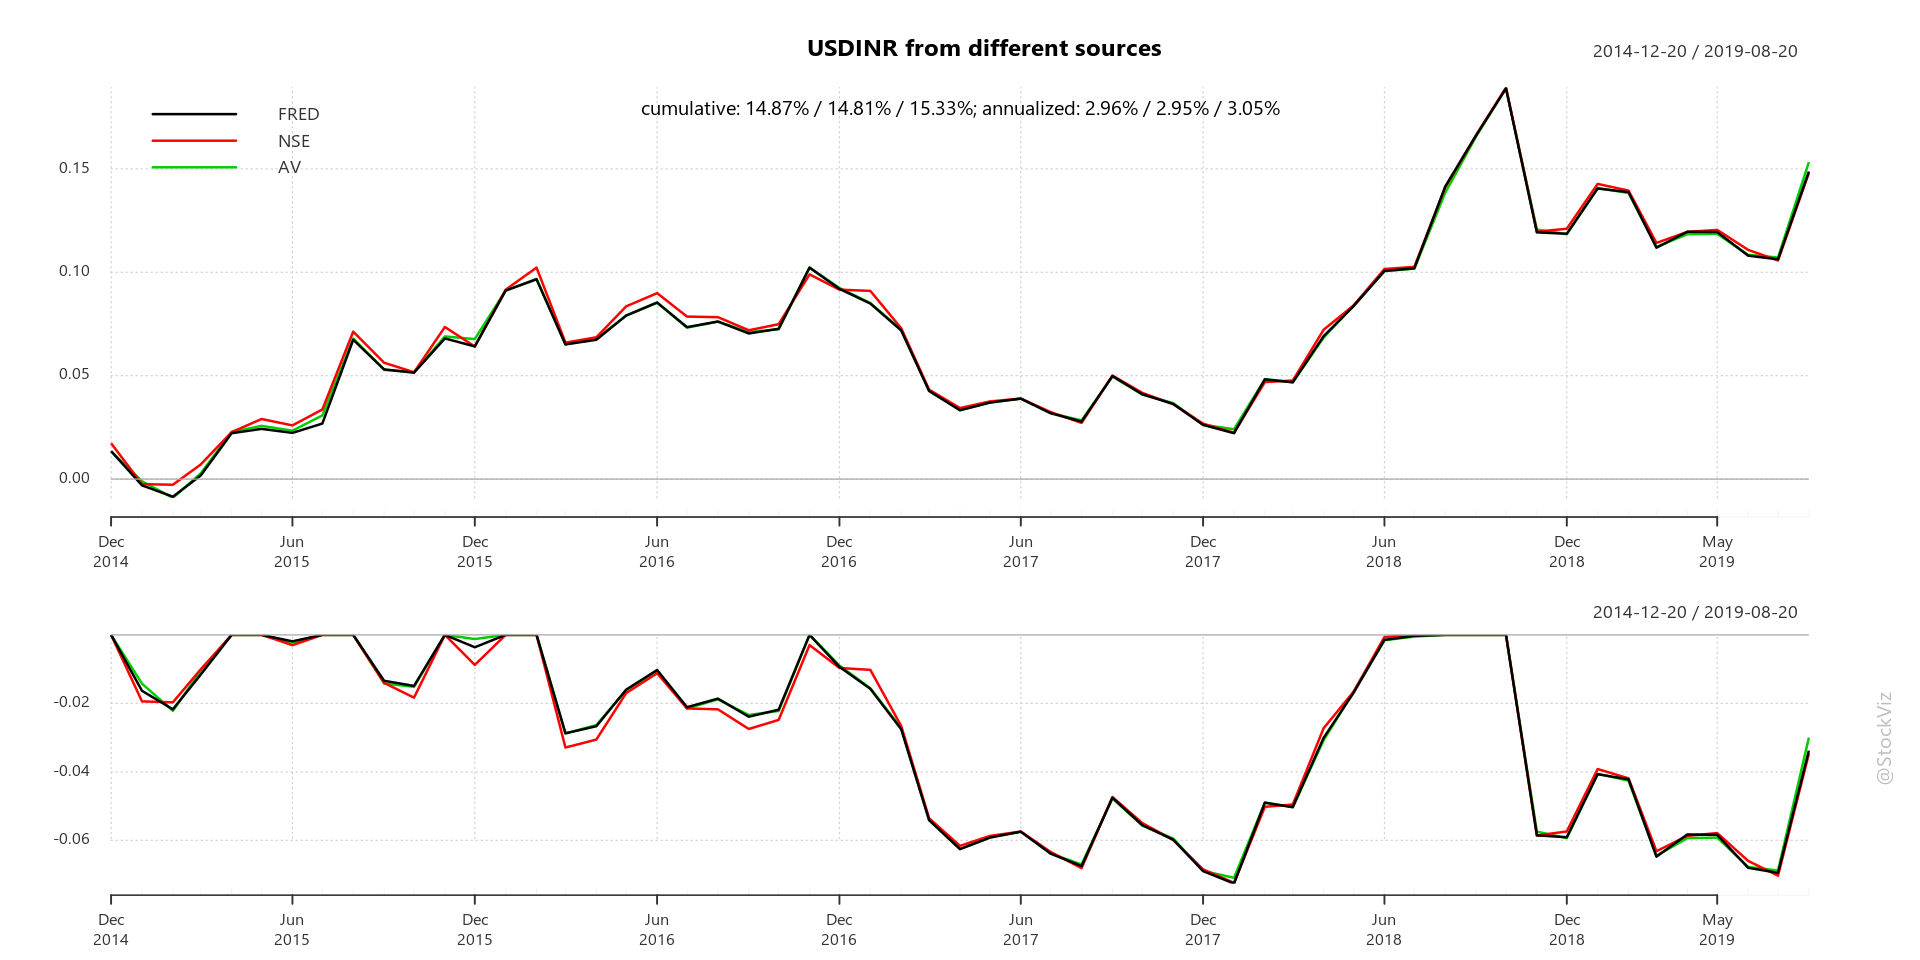

In [5]:
Common.PlotCumReturns(monthlies, "USDINR from different sources", NA)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)